In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as ss
%matplotlib inline
import seaborn as sns
import warnings 
from ta.volatility import BollingerBands
from ta.momentum import rsi,stochrsi_k
from ta.trend import cci,macd
from ta.volatility import average_true_range,BollingerBands
from ta.volume import AccDistIndexIndicator,AccDistIndexIndicator,acc_dist_index
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,log_loss,silhouette_score
from sklearn.metrics import plot_confusion_matrix,roc_curve,roc_auc_score,plot_roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

## 1. LSTM model for Nasdaq-100 Index

In [2]:
# Downloading NDX data from Yahoo Finance
ndx_data = yf.download('NDX', start='2010-01-01', end='2021-12-31')
df = pd.DataFrame(ndx_data['Adj Close'])
# Calculating returns using log differences
df['Return'] = np.log(df).diff()

# Reset the index
df = df.reset_index()
# Set the date as the new index, without time information
df['Date'] = df['Date'].dt.date
df = df.set_index('Date')

df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Return
Date,,
2009-12-31,1860.310059,NaN
2010-01-04,1886.699951,0.014086
2010-01-05,1888.430054,0.000917
2010-01-06,1878.420044,-0.005315
2010-01-07,1876.719971,-0.000905


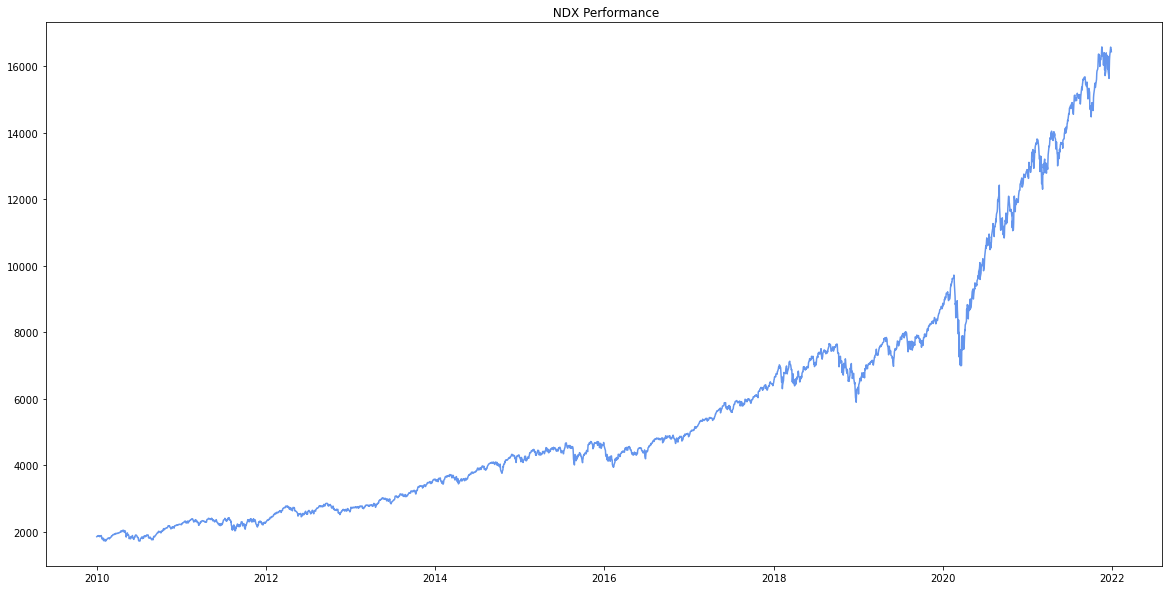

In [3]:
# Visualize raw price series
plt.figure(figsize=(20,10))
plt.title(' NDX Performance')
plt.plot(df['Adj Close'], color='cornflowerblue');

In [4]:
# Create features (predictors) list

def features(df):
    df['O-C'] = ndx_data['Open'] - ndx_data['Close']
    df['H-L'] = ndx_data['High'] - ndx_data['Low']
    #df['UpperBand'] = df['Adj Close'].rolling(20).mean() + df['Adj Close'].rolling(20).std() * 2
    #df['LowerBand'] = df['Adj Close'].rolling(20).mean() - df['Adj Close'].rolling(20).std() * 2
    df['Relative']=rsi(ndx_data['Close'],window=14)
    df['Stochatic_k']=stochrsi_k(ndx_data['Close'])
    df['CCI']=cci(ndx_data['High'],ndx_data['Low'],ndx_data['Close'])
    df["ATR"]=average_true_range(ndx_data['High'],ndx_data['Low'],ndx_data['Close'])
    df['macd']=macd(ndx_data.Close,window_fast=112,window_slow=26)
    df['AccDist']=acc_dist_index(ndx_data['High'],ndx_data['Low'],ndx_data['Close'],ndx_data['Volume'])
    df['Return_1d']= df['Return'].shift(periods=1)
    df['Return_2d']= df['Return'].shift(periods=2)
    df['Return_5d']= df['Return'].shift(periods=5)
    df['Momentum_1d']=df['Adj Close']-df['Adj Close'].shift(periods=1)
    df['Momentum_2d']=df['Adj Close']-df['Adj Close'].shift(periods=2)
    df['Momentum_5d']=df['Adj Close']-df['Adj Close'].shift(periods=5)
    df['MA_5d']=df['Adj Close'].rolling(5).mean()
    df['MA_10d']=df['Adj Close'].rolling(10).mean()
    df['MA_20d']=df['Adj Close'].rolling(20).mean()
    df['MA_50d']=df['Adj Close'].rolling(20).mean()
    df['EMA_5d']=df['Adj Close'].ewm(5, adjust=False).mean()
    df['EMA_10d']=df['Adj Close'].ewm(10, adjust=False).mean()
    df['EMA_20d']=df['Adj Close'].ewm(20, adjust=False).mean()
    df['EMA_50d']=df['Adj Close'].ewm(50, adjust=False).mean()
    return df

In [5]:
# Drift-independent volatility (YZ estimator)
def yz(df, lookback=10):
    o = df.Open
    h = df.High
    l = df.Low
    c = df.Close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(window=lookback).sum()* (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result * 100

# Volume weighted average price
def vwap(df):
    v = df['Volume'].values
    tp = (df['Low'] + df['Close'] + df['High']).div(3).values
    return df.assign(vwap=(tp * v).cumsum() / v.cumsum()).vwap

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=ndx_data["Close"], window=20, window_dev=2)
df['Bollinger_BandM']=indicator_bb.bollinger_mavg()
df['Bollinger_BandH']=indicator_bb.bollinger_hband()
df['Bollinger_BandL']=indicator_bb.bollinger_lband()

In [6]:
features(df)
df['drift_volatility']=yz(ndx_data)
df['VWAP']=vwap(ndx_data)
# Drop NaN values
df.dropna(inplace=True)
df.head()

,Adj Close,Return,Bollinger_BandM,Bollinger_BandH,Bollinger_BandL,O-C,H-L,Relative,Stochatic_k,CCI,...,MA_5d,MA_10d,MA_20d,MA_50d,EMA_5d,EMA_10d,EMA_20d,EMA_50d,drift_volatility,VWAP
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-11,1847.150024,0.009279,1842.040009,1921.341832,1762.738185,-32.900024,36.630005,47.404294,0.605689,-12.980080,...,1810.004004,1834.474011,1842.040009,1842.040009,1832.410335,1853.942195,1884.257576,1894.900802,28.093656,1890.632952
2010-06-14,1845.479980,-0.000905,1838.959009,1912.488702,1765.429315,17.219971,32.779907,47.186059,0.787535,37.199125,...,1819.467993,1833.783008,1838.959009,1838.959009,1834.588609,1853.172903,1882.411024,1893.931766,28.353870,1890.387020
2010-06-15,1897.479980,0.027787,1838.060510,1908.190066,1767.930954,-41.790039,43.100098,54.248745,0.888267,108.809949,...,1839.823999,1840.027002,1838.060510,1838.060510,1845.070504,1857.200819,1883.128593,1894.001339,27.238999,1890.334867
2010-06-16,1905.310059,0.004118,1838.973010,1912.042383,1765.903638,-14.050049,24.989990,55.219824,0.942009,151.450672,...,1865.102002,1842.599011,1838.973010,1838.973010,1855.110430,1861.574386,1884.184853,1894.223078,26.289391,1890.416414
2010-06-17,1910.650024,0.002799,1840.834509,1919.035991,1762.633028,4.099976,21.969971,55.907172,1.000000,149.710801,...,1881.214014,1844.098010,1840.834509,1840.834509,1864.367029,1866.035808,1885.445100,1894.545175,26.359104,1890.522875


# Assigning the Label

The label is a crucial component that determines the outcome of the prediction made by the Long Short-Term Memory (LSTM) model.
The label represents the target variable, or the dependent variable, which the model is trying to predict. 
In this case, the target variable is whether the NDX index price will close up or down on the next trading day. 
Based on this prediction, a decision is made to either buy the NDX (if the tomorrow's closing price is greater than today's closing price) or sell SPY (if the tomorrow's closing price is lower than today's closing price).
If there is no change between the closing prices of today's and tomorrow's, then the position is considered neutral. 
In short, the label provides the ground truth for the LSTM model to make predictions and help traders make informed investment decisions.

Assigning +1 for the buy signal and 0 for sell. Target can be described as:

\begin{equation}
y_t= \begin{cases}+1, & \text { if } p_t+1>p_t \\ 0, & \text { if } p_t+1<p_t\end{cases}
\end{equation}    

In [7]:
df['Target']=np.where(df['Adj Close'].shift(-1)>df['Adj Close'],1,np.where(df['Adj Close'].shift(-1)<df['Adj Close'],0,-1))
df.drop(df[df['Target']==-1].index,inplace=True)
df['Target'].value_counts(normalize=True)

1    0.560179
0    0.439821
Name: Target, dtype: float64

/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Target', ylabel='count'>

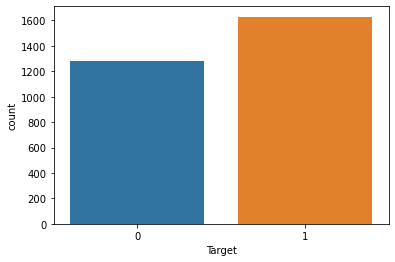

In [8]:
# The -1 classes were excluded from the dataset due to a small sample size and to prevent over- or under-prediction in the other classes, which are +1 and 0.

sns.countplot(df['Target'])

Text(0.5, 1.0, 'Feature Correlation')

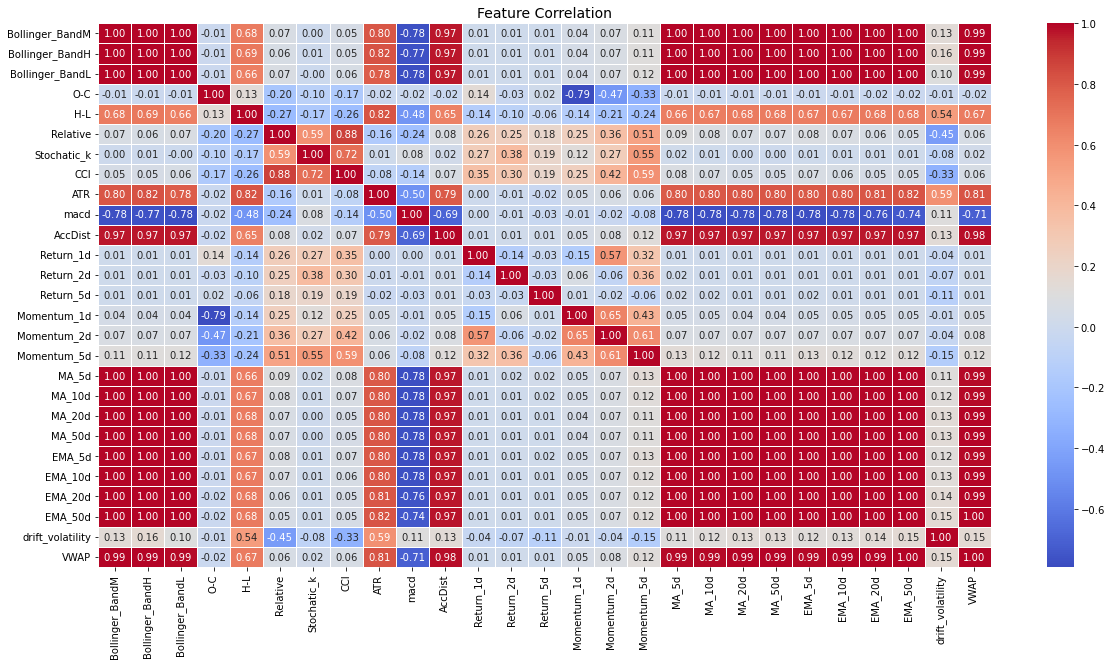

In [9]:
# Compute features correlation
import seaborn as sns
corrmat = df.drop(['Adj Close', 'Return', 'Target'],axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, cmap="coolwarm")
ax.set_title('Feature Correlation', fontsize=14, color='black')

The features MA_5d, MA_10d, MA_20d, MA_50d, EMA_5d, EMA_10d, EMA20d, and EMA_50d in the correlation matrix are found to be highly correlated with each other. As a result, only one of these features will be selected for model construction. This correlation is also seen between Bollinger bands and VWAP.

# K means Clustering

In [10]:
df1=df.copy()
df1=df1.T
df1=df1.drop(['Adj Close','Target'])

In [11]:
X1=df1.iloc[:]
scaler_x = StandardScaler()
X1= scaler_x.fit_transform(X1)
X1.shape

/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date']. An error will be raised in 1.2.
  FutureWarning,
/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date']. An error will be raised in 1.2.
  FutureWarning,


(28, 2908)

In [12]:
# implementing K-means clustering
score=[]
for k in range(2,13):
    model=KMeans(n_clusters=k)
    model.fit(X1)
    labels=model.labels_
    centroids = model.cluster_centers_
    score.append(model.inertia_)

/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  """
/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  """
/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  """


In [13]:
clusters_df = pd.DataFrame({"Clusters": range(2,13), "Cluster_errors": score})
clusters_df

,Clusters,Cluster_errors
0,2,1.375962e-10
1,3,2.276197e-12
2,4,2.216881e-13
3,5,1.690839e-13
4,6,1.336672e-13
5,7,1.156567e-13
6,8,7.894351e-14
7,9,5.592890e-14
8,10,5.561421e-14
9,11,4.960283e-14


### Using the Elbow graph to Identify the appropriate clusters

Text(0, 0.5, 'Model Inertia')

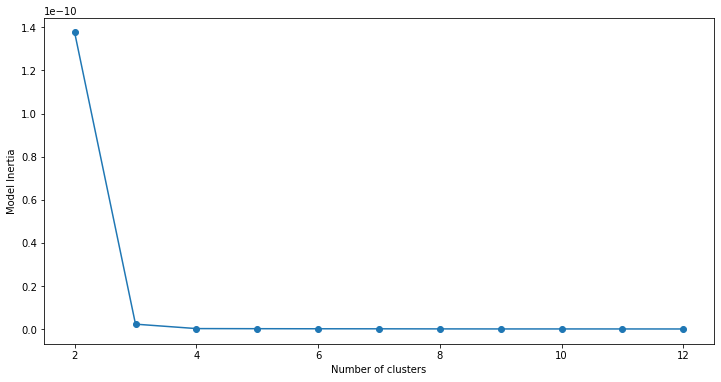

In [14]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.Clusters, clusters_df.Cluster_errors, marker = "o" )
plt.xlabel("Number of clusters")
plt.ylabel("Model Inertia")

Based on the Elbow plot, there is a noticeable bend at 3, therefore we have adjusted the KMeans clustering to have 3 clusters.

In [15]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X1)

KMeans(n_clusters=3, random_state=1)

In [16]:
predictions=kmeans.predict(X1)
predictions

array([0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2], dtype=int32)

### Cluster Analysis

In [17]:
df_cluster=pd.DataFrame({'Cluster':predictions,'Features':df1.index,
                         'Distance':df1.mean(axis=1),'Std Dev':df1.std(axis=1)}).sort_values(by=['Cluster'],axis=0)
df_cluster

,Cluster,Features,Distance,Std Dev
Return,0,Return,7.547421e-04,1.240353e-02
Momentum_5d,0,Momentum_5d,2.510156e+01,1.801561e+02
Momentum_2d,0,Momentum_2d,1.008654e+01,1.170344e+02
Momentum_1d,0,Momentum_1d,5.038256e+00,9.060487e+01
Return_5d,0,Return_5d,7.334613e-04,1.243170e-02
drift_volatility,0,drift_volatility,1.789404e+01,1.039608e+01
Return_1d,0,Return_1d,7.618578e-04,1.241269e-02
macd,0,macd,-1.984335e+02,2.606565e+02
ATR,0,ATR,8.582128e+01,7.415039e+01
Return_2d,0,Return_2d,7.616143e-04,1.241461e-02


### SOM Implementation

In [25]:
df2 = pd.DataFrame(df_cluster)
X_SOM=df2[['Distance','Std Dev']]

scaler = StandardScaler()
X_SOM = scaler.fit_transform(X_SOM)

# Check if the array has any missing or NaN values
print(np.isnan(X_SOM).sum())

# Check if the array has any values for index 0
print(X_SOM[0])

# Initialize a 15x15 SOM
som = MiniSom(15, 15, 2, learning_rate=0.5, sigma=5, random_seed=42)

# Initialize with random weights
som.random_weights_init(X_SOM)

# Trains SOM with 10000 iterations
som.train_batch(X_SOM, 10000, verbose=True)

0
[-0.19245012 -0.19245012]


 [   668 / 10000 ]   7% - 0:00:05 left 

 [  1194 / 10000 ]  12% - 0:00:04 left 

 [  1515 / 10000 ]  15% - 0:00:04 left 

 [  1860 / 10000 ]  19% - 0:00:04 left 

 [  2406 / 10000 ]  24% - 0:00:04 left 

 [  2842 / 10000 ]  28% - 0:00:03 left 

 [  3470 / 10000 ]  35% - 0:00:03 left 

 [  3763 / 10000 ]  38% - 0:00:03 left 

 [  4040 / 10000 ]  40% - 0:00:03 left 

 [  4590 / 10000 ]  46% - 0:00:02 left 

 [  5019 / 10000 ]  50% - 0:00:02 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.6251601282067977e-09


/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/minisom.py:536: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


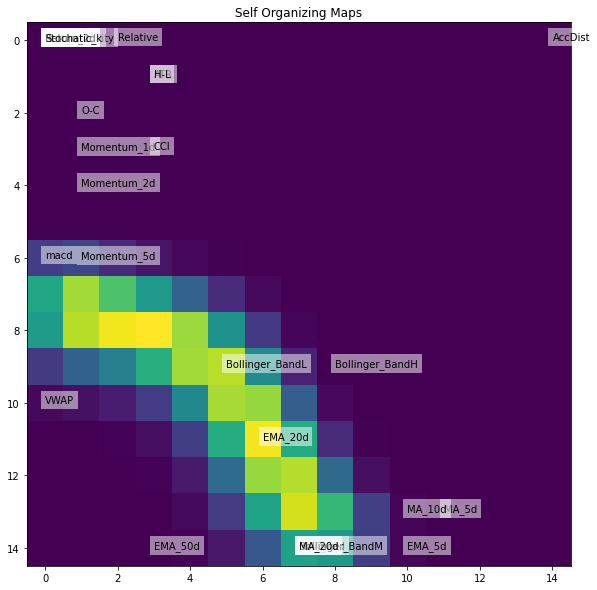

In [26]:
# Plotting SOM
plt.figure(figsize=(20, 10))
for ix in range(len(X_SOM)):
    winner = som.winner(X_SOM[ix])
    plt.text(winner[0], winner[1], df_cluster.Features[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.grid(False)
plt.title('Self Organizing Maps');

The SOM was trained using the feature set X, and each data point was labeled based on the neuron it was assigned to in the SOM.

## Training the Model and Data Splitting

In [29]:
X_cols = [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 18, 22, 23, 27, 28]
X = df.iloc[:, X_cols].values

y = df.iloc[:, -1].values.reshape(-1, 1)

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
X.shape

(2908, 17)

In [30]:
def lstm_data_transform(x_data, y_data, num_steps):
    x_shape = (x_data.shape[0] - num_steps, num_steps, x_data.shape[1])
    x_array = np.zeros(x_shape)
    y_array = y_data[num_steps:]
    for i in range(num_steps):
        x_array[:, i, :] = x_data[i:x_shape[0]+i]
    return x_array, y_array

In [31]:
num_steps_list = [5, 10, 21, 50, 200]
for num_steps in num_steps_list:
    X_new, y_new = lstm_data_transform(X, y, num_steps=num_steps)
    print("The new shape of x is", X_new.shape)
    print("\n")

The new shape of x is (2903, 5, 17)


The new shape of x is (2898, 10, 17)


The new shape of x is (2887, 21, 17)


The new shape of x is (2858, 50, 17)


The new shape of x is (2708, 200, 17)




To use LSTM, the input data must have three dimensions in the format of [samples, timesteps, features].

In [32]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    # Print the shape of the train data for the current num_steps value
    print(f"The new shape of x for num_steps={n} is {x_train.shape}")
    print()

The new shape of x for num_steps=5 is (2032, 5, 17)

The new shape of x for num_steps=10 is (2028, 10, 17)

The new shape of x for num_steps=21 is (2020, 21, 17)

The new shape of x for num_steps=50 is (2000, 50, 17)

The new shape of x for num_steps=200 is (1895, 200, 17)



In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def base_model(X_new):
    # Define the model
    model = Sequential([
        LSTM(units=200, return_sequences=True, input_shape=(X_new.shape[1], X_new.shape[2])),
        Dropout(0.2),
        LSTM(units=100, activation='sigmoid', return_sequences=True),
        Dropout(0.2),
        LSTM(units=100, activation='sigmoid', return_sequences=True),
        Dropout(0.2),
        LSTM(units=100, activation='sigmoid', return_sequences=True),
        Dropout(0.2),
        LSTM(units=100),
        Dropout(0.2),
        Dense(units=100, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Print the model summary
    model.summary()
    return model

### Implementing an LSTM model with a 5-day lookback period

In [37]:
# Transform the data with 5 timesteps
X_new5, y_new5 = lstm_data_transform(X, y, num_steps=5)

# Print the new shape of X for num_steps=5
print(f"The new shape of X for num_steps=5 is {X_new5.shape}")

# Build the LSTM model using the transformed data with 5 timesteps
model5 = base_model(X_new5)

The new shape of X for num_steps=5 is (2903, 5, 17)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 200)            174400    
_________________________________________________________________
dropout (Dropout)            (None, 5, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 100)            120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm

In [41]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
# Use the train and test data for num_steps=5 only
x_train_5 = x_train_list[0]
y_train_5 = y_train_list[0]
x_test_5 = x_test_list[0]
y_test_5 = y_test_list[0]

# Train and evaluate the model for num_steps=5
hist5=model5.fit(x_train_5,y_train_5,epochs=10,batch_size=64)
Eva5=model5.evaluate(x_test_5,y_test_5)
print('Test accuracy: ', np.round(Eva5[1],4))

Epoch 1/10
32/32 [==============================] - 13s 144ms/step - loss: 0.6895 - accuracy: 0.5522
Epoch 2/10
32/32 [==============================] - 4s 127ms/step - loss: 0.6913 - accuracy: 0.5285
Epoch 3/10
32/32 [==============================] - 4s 126ms/step - loss: 0.6908 - accuracy: 0.5502
Epoch 4/10
32/32 [==============================] - 4s 127ms/step - loss: 0.6896 - accuracy: 0.5507
Epoch 5/10
32/32 [==============================] - 4s 134ms/step - loss: 0.6898 - accuracy: 0.5507
Epoch 6/10
32/32 [==============================] - 5s 171ms/step - loss: 0.6890 - accuracy: 0.5507
Epoch 7/10
32/32 [==============================] - 5s 140ms/step - loss: 0.6886 - accuracy: 0.5507
Epoch 8/10
32/32 [==============================] - 4s 137ms/step - loss: 0.6884 - accuracy: 0.5507
Epoch 9/10
32/32 [==============================] - 5s 142ms/step - loss: 0.6885 - accuracy: 0.5507
Epoch 10/10
28/28 [==============================] - 3s 31ms/step - loss: 0.6814 - accuracy: 0.5809

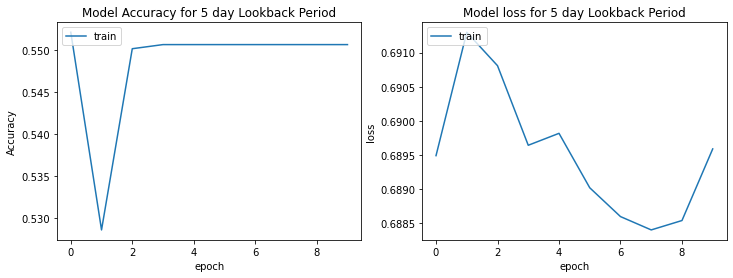

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist5.history['accuracy'])
ax1.set_title("Model Accuracy for 5 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("epoch")
ax1.legend(['train'], loc='upper left')

# Plot loss
ax2.plot(hist5.history['loss'])
ax2.set_title('Model loss for 5 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train'], loc='upper left')

plt.show()

#### Confusion Matrix

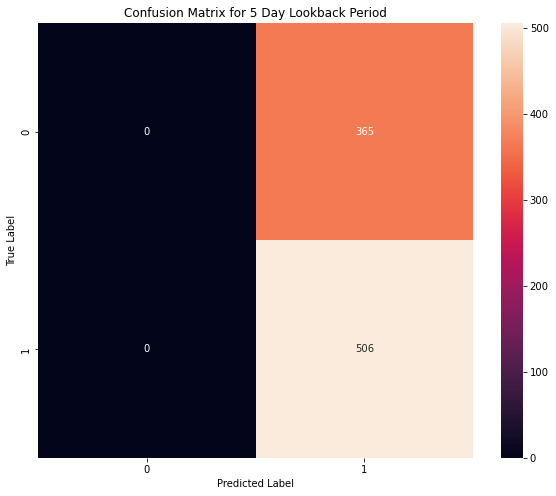

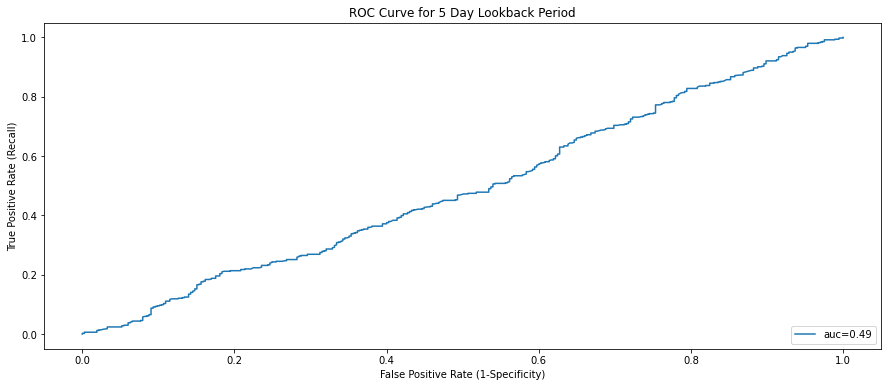

In [51]:
# Confusion Matrix
y_pred5=model5.predict(x_test_5)
y_pred5 = np.round(y_pred5).astype(int)
cm5=confusion_matrix(y_test_5,y_pred5)
plt.figure(figsize=(10,8))
sns.heatmap(cm5,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 5 Day Lookback Period")

y_prob5=model5.predict(x_test_5)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_5,y_prob5),2)
fpr,tpr,_=roc_curve(y_test_5,y_prob5, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 5 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Implementing an LSTM model with a 10-day lookback period

In [53]:
# Transform the data with 10 timesteps
X_new10, y_new10 = lstm_data_transform(X, y, num_steps=10)

# Print the new shape of X for num_steps=10
print(f"The new shape of X for num_steps=10 is {X_new10.shape}")

# Build the LSTM model using the transformed data with 10 timesteps
model10 = base_model(X_new10)

The new shape of X for num_steps=10 is (2898, 10, 17)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10, 200)           174400    
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 100)           120400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 10, 100)           80400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________


In [79]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
# Use the train and test data for num_steps=10 only
x_train_10 = x_train_list[1]
y_train_10 = y_train_list[1]
x_test_10 = x_test_list[1]
y_test_10 = y_test_list[1]

# Train and evaluate the model for num_steps=10
hist10=model10.fit(x_train_10,y_train_10,epochs=10,batch_size=64)
Eva10=model10.evaluate(x_test_10,y_test_10)
print('Test accuracy: ', np.round(Eva10[1],4))

Epoch 1/10
32/32 [==============================] - 7s 207ms/step - loss: 0.7103 - accuracy: 0.5182
Epoch 2/10
32/32 [==============================] - 7s 219ms/step - loss: 0.6895 - accuracy: 0.5518
Epoch 3/10
32/32 [==============================] - 7s 229ms/step - loss: 0.6888 - accuracy: 0.5483
Epoch 4/10
32/32 [==============================] - 7s 232ms/step - loss: 0.6879 - accuracy: 0.5518
Epoch 5/10
32/32 [==============================] - 7s 221ms/step - loss: 0.6883 - accuracy: 0.5513
Epoch 6/10
32/32 [==============================] - 7s 233ms/step - loss: 0.6887 - accuracy: 0.5518
Epoch 7/10
32/32 [==============================] - 7s 226ms/step - loss: 0.6881 - accuracy: 0.5518
Epoch 8/10
32/32 [==============================] - 8s 257ms/step - loss: 0.6885 - accuracy: 0.5513
Epoch 9/10
32/32 [==============================] - 8s 233ms/step - loss: 0.6884 - accuracy: 0.5523
Epoch 10/10
28/28 [==============================] - 1s 43ms/step - loss: 0.6842 - accuracy: 0.5816


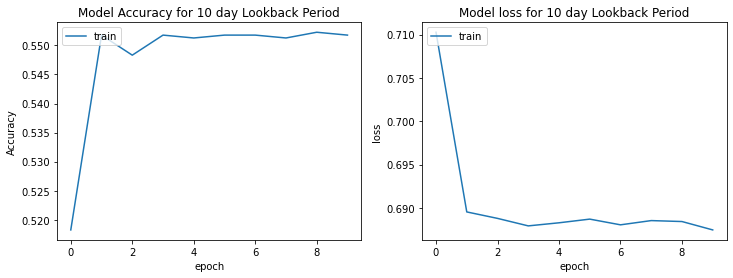

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist10.history['accuracy'])
ax1.set_title("Model Accuracy for 10 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("epoch")
ax1.legend(['train'], loc='upper left')

# Plot loss
ax2.plot(hist10.history['loss'])
ax2.set_title('Model loss for 10 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train'], loc='upper left')

plt.show()

#### Confusion Matrix

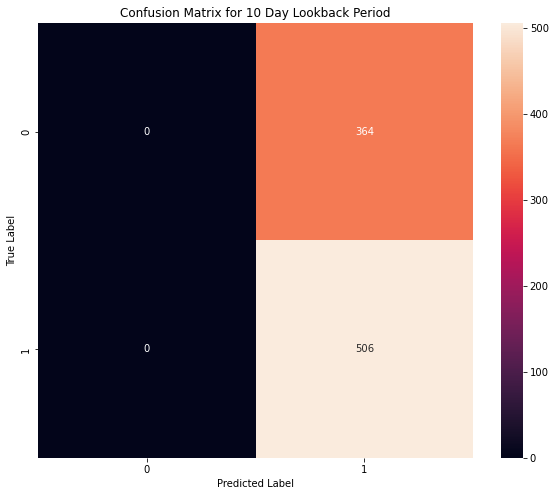

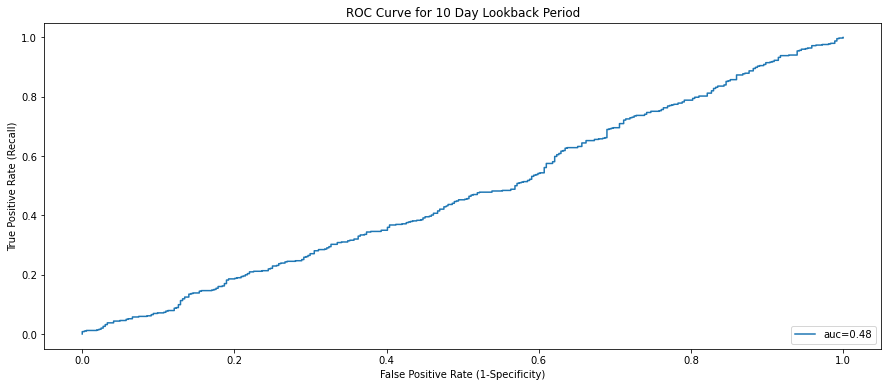

In [81]:
# Confusion Matrix
y_pred10=model10.predict(x_test_10)
y_pred10 = np.round(y_pred10).astype(int)
cm_10=confusion_matrix(y_test_10,y_pred10)
plt.figure(figsize=(10,8))
sns.heatmap(cm_10,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 10 Day Lookback Period")

y_prob10=model10.predict(x_test_10)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_10,y_prob10),2)
fpr,tpr,_=roc_curve(y_test_10,y_prob10, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 10 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Implementing an LSTM model with a 21-day lookback period

In [59]:
# Transform the data with 21 timesteps
X_new21, y_new21 = lstm_data_transform(X, y, num_steps=21)

# Print the new shape of X for num_steps=21
print(f"The new shape of X for num_steps=21 is {X_new21.shape}")

# Build the LSTM model using the transformed data with 21 timesteps
model21 = base_model(X_new21)

The new shape of X for num_steps=21 is (2887, 21, 17)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 21, 200)           174400    
_________________________________________________________________
dropout_15 (Dropout)         (None, 21, 200)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 21, 100)           120400    
_________________________________________________________________
dropout_16 (Dropout)         (None, 21, 100)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 21, 100)           80400     
_________________________________________________________________
dropout_17 (Dropout)         (None, 21, 100)           0         
_________________________________________________________________


In [82]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
# Use the train and test data for num_steps=21 only
x_train_21 = x_train_list[2]
y_train_21 = y_train_list[2]
x_test_21 = x_test_list[2]
y_test_21 = y_test_list[2]

# Train and evaluate the model for num_steps=21
hist21=model21.fit(x_train_21,y_train_21,epochs=10,batch_size=64)
Eva21=model21.evaluate(x_test_21,y_test_21)
print('Test accuracy: ', np.round(Eva21[1],4))

Epoch 1/10
32/32 [==============================] - 18s 572ms/step - loss: 0.6920 - accuracy: 0.5460
Epoch 2/10
32/32 [==============================] - 16s 481ms/step - loss: 0.6899 - accuracy: 0.5495
Epoch 3/10
32/32 [==============================] - 16s 509ms/step - loss: 0.6900 - accuracy: 0.5490
Epoch 4/10
32/32 [==============================] - 15s 464ms/step - loss: 0.6879 - accuracy: 0.5515
Epoch 5/10
32/32 [==============================] - 15s 459ms/step - loss: 0.6880 - accuracy: 0.5515
Epoch 6/10
32/32 [==============================] - 14s 432ms/step - loss: 0.6893 - accuracy: 0.5391
Epoch 7/10
32/32 [==============================] - 14s 427ms/step - loss: 0.6895 - accuracy: 0.5515
Epoch 8/10
32/32 [==============================] - 14s 437ms/step - loss: 0.6887 - accuracy: 0.5515
Epoch 9/10
32/32 [==============================] - 14s 433ms/step - loss: 0.6888 - accuracy: 0.5515
Epoch 10/10
28/28 [==============================] - 3s 102ms/step - loss: 0.6799 - accurac

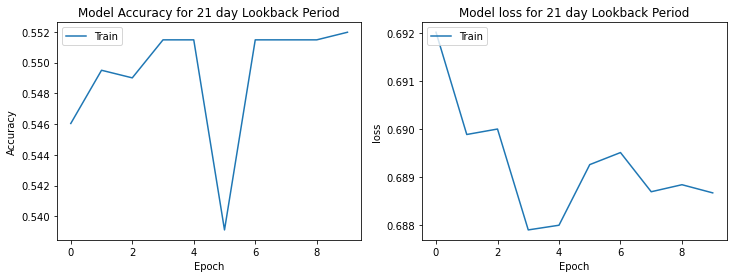

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist21.history['accuracy'])
ax1.set_title("Model Accuracy for 21 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(['Train'], loc='upper left')

# Plot loss
ax2.plot(hist21.history['loss'])
ax2.set_title('Model loss for 21 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train'], loc='upper left')

plt.show()

#### Confusion Matrix

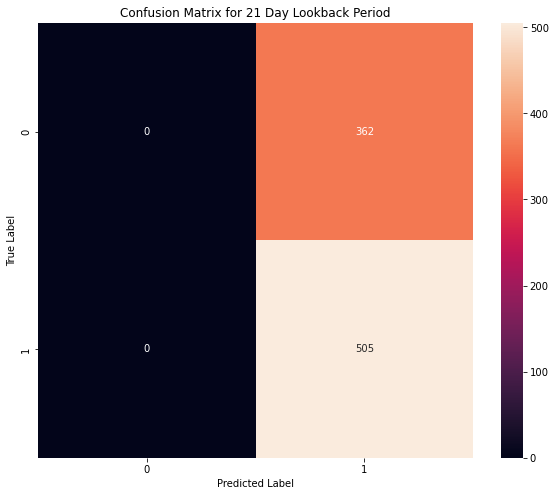

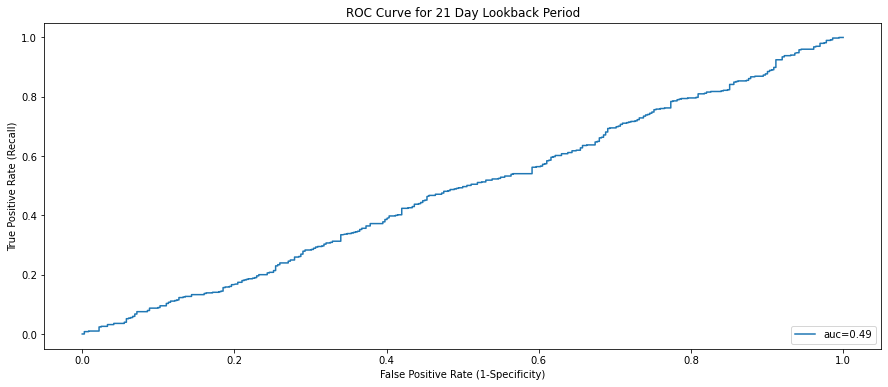

In [84]:
# Confusion Matrix
y_pred21=model21.predict(x_test_21)
y_pred21 = np.round(y_pred21).astype(int)
cm_21=confusion_matrix(y_test_21,y_pred21)
plt.figure(figsize=(10,8))
sns.heatmap(cm_21,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 21 Day Lookback Period")

y_prob21=model21.predict(x_test_21)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_21,y_prob21),2)
fpr,tpr,_=roc_curve(y_test_21,y_prob21, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 21 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Implementing an LSTM model with a 50-day lookback period

In [65]:
# Transform the data with 21 timesteps
X_new50, y_new50 = lstm_data_transform(X, y, num_steps=50)

# Print the new shape of X for num_steps=50
print(f"The new shape of X for num_steps=50 is {X_new50.shape}")

# Build the LSTM model using the transformed data with 50 timesteps
model50 = base_model(X_new50)

The new shape of X for num_steps=50 is (2858, 50, 17)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 50, 200)           174400    
_________________________________________________________________
dropout_20 (Dropout)         (None, 50, 200)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 50, 100)           120400    
_________________________________________________________________
dropout_21 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________


In [91]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
# Use the train and test data for num_steps=50 only
x_train_50 = x_train_list[3]
y_train_50 = y_train_list[3]
x_test_50 = x_test_list[3]
y_test_50 = y_test_list[3]

# Train and evaluate the model for num_steps=50
hist50=model50.fit(x_train_50,y_train_50,epochs=10,batch_size=64)
Eva50=model50.evaluate(x_test_50,y_test_50)
print('Test accuracy: ', np.round(Eva50[1],4))

Epoch 1/10
32/32 [==============================] - 29s 858ms/step - loss: 0.6885 - accuracy: 0.5525
Epoch 2/10
32/32 [==============================] - 30s 946ms/step - loss: 0.6897 - accuracy: 0.5525
Epoch 3/10
32/32 [==============================] - 25s 763ms/step - loss: 0.6876 - accuracy: 0.5525
Epoch 4/10
32/32 [==============================] - 24s 735ms/step - loss: 0.6888 - accuracy: 0.5525
Epoch 5/10
32/32 [==============================] - 23s 716ms/step - loss: 0.6890 - accuracy: 0.5530
Epoch 6/10
32/32 [==============================] - 27s 856ms/step - loss: 0.6879 - accuracy: 0.5525
Epoch 7/10
32/32 [==============================] - 23s 733ms/step - loss: 0.6888 - accuracy: 0.5525
Epoch 8/10
32/32 [==============================] - 23s 702ms/step - loss: 0.6888 - accuracy: 0.5525
Epoch 9/10
32/32 [==============================] - 22s 685ms/step - loss: 0.6888 - accuracy: 0.5525
Epoch 10/10
27/27 [==============================] - 4s 120ms/step - loss: 0.6819 - accurac

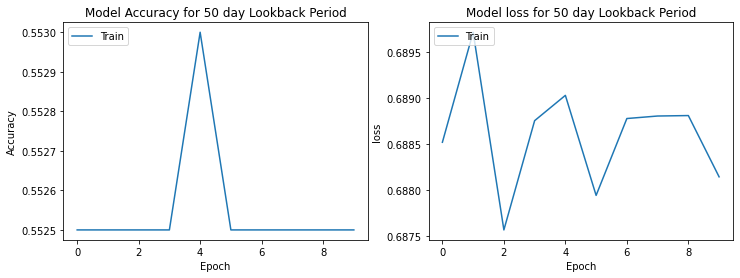

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist50.history['accuracy'])
ax1.set_title("Model Accuracy for 50 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(['Train'], loc='upper left')

# Plot loss
ax2.plot(hist50.history['loss'])
ax2.set_title('Model loss for 50 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train'], loc='upper left')

plt.show()

#### Confusion Matrix

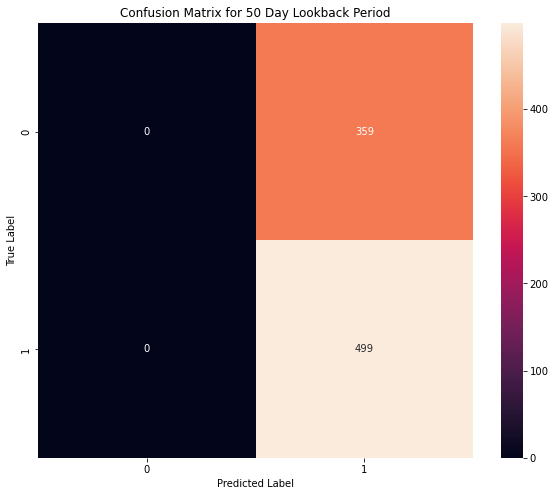

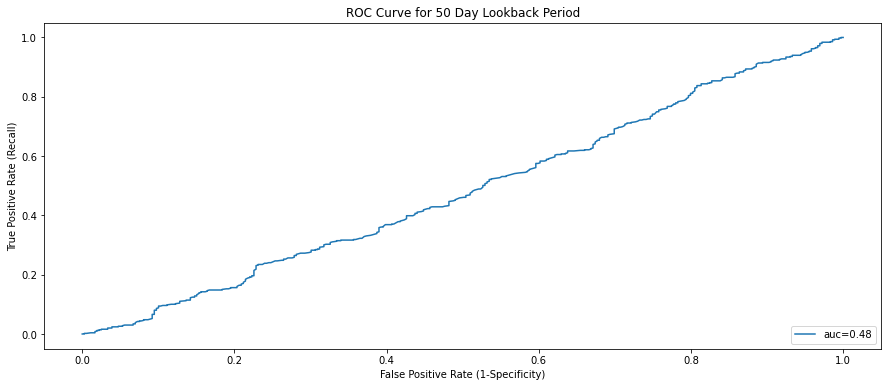

In [93]:
# Confusion Matrix
y_pred50=model50.predict(x_test_50)
y_pred50 = np.round(y_pred50).astype(int)
cm_50=confusion_matrix(y_test_50,y_pred50)
plt.figure(figsize=(10,8))
sns.heatmap(cm_50,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 50 Day Lookback Period")

y_prob50=model50.predict(x_test_50)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_50,y_prob50),2)
fpr,tpr,_=roc_curve(y_test_50,y_prob50, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 50 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Implementing an LSTM model with a 200-day lookback period

In [88]:
# Transform the data with 200 timesteps
X_new200, y_new200 = lstm_data_transform(X, y, num_steps=200)

# Print the new shape of X for num_steps=200
print(f"The new shape of X for num_steps=200 is {X_new200.shape}")

# Build the LSTM model using the transformed data with 200 timesteps
model200 = base_model(X_new200)

The new shape of X for num_steps=200 is (2708, 200, 17)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 200, 200)          174400    
_________________________________________________________________
dropout_25 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 200, 100)          120400    
_________________________________________________________________
dropout_26 (Dropout)         (None, 200, 100)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 200, 100)          80400     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200, 100)          0         
________________________________________________________________

In [89]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
# Use the train and test data for num_steps=200 only
x_train_200 = x_train_list[4]
y_train_200 = y_train_list[4]
x_test_200 = x_test_list[4]
y_test_200 = y_test_list[4]

# Train and evaluate the model for num_steps=200
hist200=model200.fit(x_train_200,y_train_200,epochs=10,batch_size=64)
Eva200=model200.evaluate(x_test_200,y_test_200)
print('Test accuracy: ', np.round(Eva200[1],4))

Epoch 1/10
30/30 [==============================] - 219s 6s/step - loss: 0.6951 - accuracy: 0.5335
Epoch 2/10
30/30 [==============================] - 165s 5s/step - loss: 0.6919 - accuracy: 0.5398
Epoch 3/10
30/30 [==============================] - 147s 5s/step - loss: 0.6896 - accuracy: 0.5472
Epoch 4/10
30/30 [==============================] - 112s 3s/step - loss: 0.6919 - accuracy: 0.5462
Epoch 5/10
30/30 [==============================] - 98s 3s/step - loss: 0.6906 - accuracy: 0.5404
Epoch 6/10
30/30 [==============================] - 127s 4s/step - loss: 0.6911 - accuracy: 0.5314
Epoch 7/10
30/30 [==============================] - 110s 4s/step - loss: 0.6910 - accuracy: 0.5504
Epoch 8/10
30/30 [==============================] - 95s 3s/step - loss: 0.6914 - accuracy: 0.5488
Epoch 9/10
30/30 [==============================] - 88s 3s/step - loss: 0.6902 - accuracy: 0.5483
Epoch 10/10
26/26 [==============================] - 15s 454ms/step - loss: 0.6851 - accuracy: 0.5855
Test accur

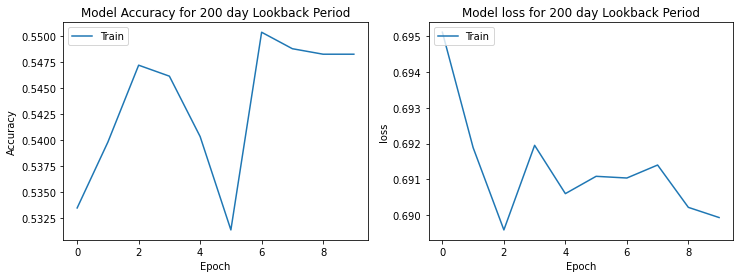

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist200.history['accuracy'])
ax1.set_title("Model Accuracy for 200 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(['Train'], loc='upper left')

# Plot loss
ax2.plot(hist200.history['loss'])
ax2.set_title('Model loss for 200 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train'], loc='upper left')

plt.show()

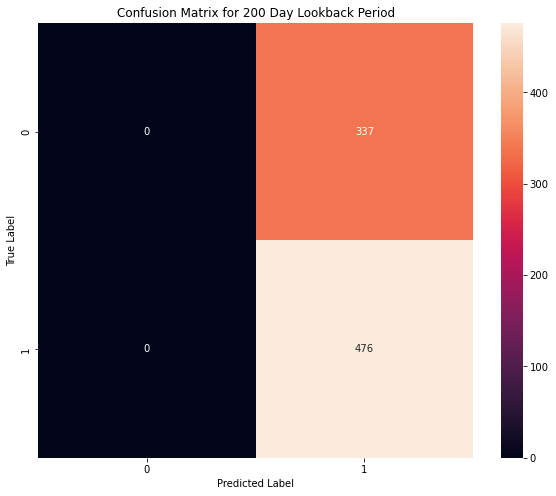

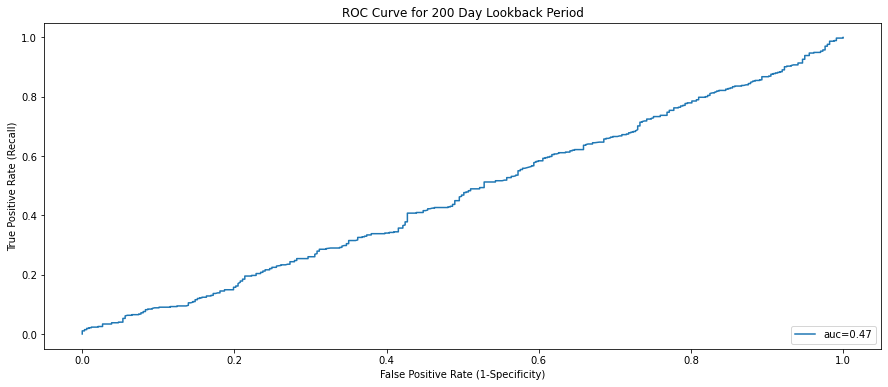

In [96]:
# Confusion Matrix
y_pred200=model200.predict(x_test_200)
y_pred200 = np.round(y_pred200).astype(int)
cm_200=confusion_matrix(y_test_200,y_pred200)
plt.figure(figsize=(10,8))
sns.heatmap(cm_200,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 200 Day Lookback Period")

y_prob200=model200.predict(x_test_200)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_200,y_prob200),2)
fpr,tpr,_=roc_curve(y_test_200,y_prob200, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 200 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

## 2. LSTM model for EUR/USD FX rate.

In [97]:
# Downloading EUR/USD data from Yahoo Finance
ndx_data = yf.download('EURUSD=X', start='2010-01-01', end='2021-12-31')
df = pd.DataFrame(ndx_data['Adj Close'])
# Calculating returns using log differences
df['Return'] = np.log(df).diff()

# Reset the index
df = df.reset_index()
# Set the date as the new index, without time information
df['Date'] = df['Date'].dt.date
df = df.set_index('Date')

df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Return
Date,,
2009-12-31,1.432706,NaN
2010-01-01,1.438994,0.004379
2010-01-04,1.442398,0.002363
2010-01-05,1.436596,-0.004031
2010-01-06,1.440403,0.002647


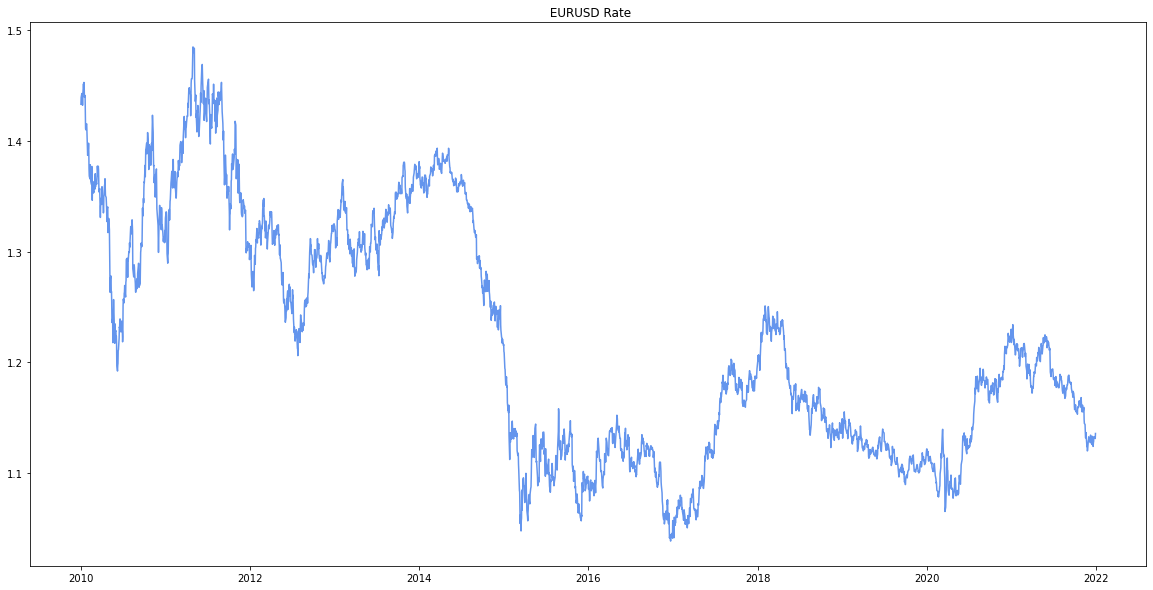

In [98]:
# Visualize raw price series
plt.figure(figsize=(20,10))
plt.title(' EURUSD Rate')
plt.plot(df['Adj Close'], color='cornflowerblue');